In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from util_functions import plot_feature_with_anomalies, remove_outliers, wavelet_denoise, savitzky_golay, rolling_median_filter

In [32]:
# Set Pandas to display all columns (None means no limit on the number of columns displayed)
pd.set_option('display.max_columns', None)

# Set option to display float format
pd.set_option('display.float_format', lambda x: '%.3f' % x) # This will help avoid issue of numeric values that are in the form of power (scientific notation) when you load them with pandas

In [33]:
# Function to check if variable is defined
def is_defined(variable_name):
    return variable_name in globals()

# Initial file paths
dasiv01 = 'Original_labeled_datasets/dt1_solar_and_meteorological_measurement.csv'
dasiv02 = 'Original_labeled_datasets/dt2_electrical_production_inverter_1_with_faults.csv'

# load the data if it is not already loaded
while not (is_defined('weather_data') and is_defined('df1')):
            weather_data = pd.read_csv(dasiv01, index_col='time')
            print("Weather data loaded successfully.")

            df1 = pd.read_csv(dasiv02, index_col='time')
            print("Electrical production data loaded successfully.")

df = df1.copy()
weather = weather_data.copy()

In [34]:
df = df.join(weather)
df.index = pd.to_datetime(df.index)
df.index = df.index.tz_convert(None) # Remove timezone information to avoid issues with decomposition

In [35]:
# rename the columns
df.rename(columns={'GTI': 'global_tilted_irradiance', 
                   'DTI': 'diffuse_tilted_irradiance', 
                   'TA': 'ambient_temperature', 
                   'TPV': 'panel_temperature', 
                   'Eg': 'energy_injected',
                   'Pg': 'power_injected', 
                   'Ia': 'ambient_current', 
                   'Ig': 'current_injected',
                   'Va': 'pv_plant_voltage',
                   'Vg': 'grid_voltage',
                   'Fg': 'grid_frequency'}, inplace=True)

#### Address outliers by capping their values

In [36]:
# address outliers by capping their values
df = remove_outliers(df, lower_percentile=0.01, upper_percentile=0.99)

### Denoise the data

In [37]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

# Identify numerical columns
numeric_columns = df.drop(columns=['Fault']).select_dtypes(include=[np.number]).columns

# Apply wavelet denoising to each numerical column
for column in numeric_columns:
    df[column] = rolling_median_filter(df[column], window=5)

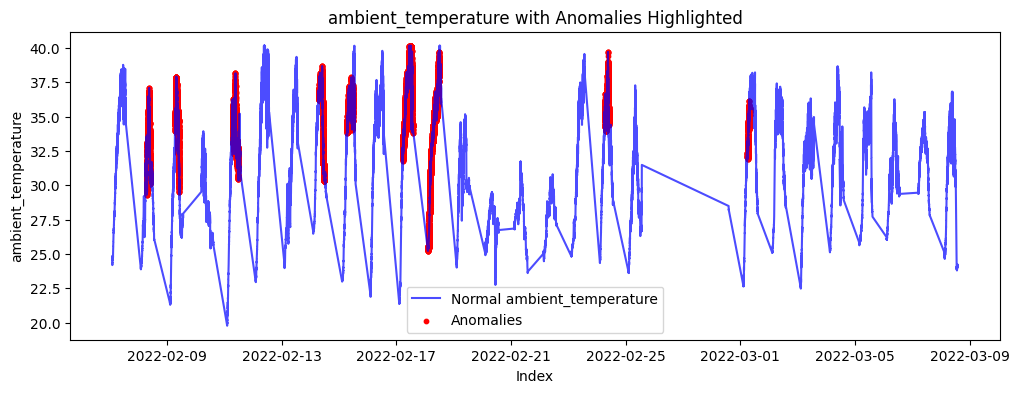

In [38]:
feature = 'ambient_temperature'
start_date = '2022-02-07'
end_date = pd.to_datetime(start_date) + pd.Timedelta(days=30)

plot_feature_with_anomalies(df[start_date:end_date], feature)
# plot_feature_with_anomalies(df[start_date:end_date], f'{feature}_denoised')

In [39]:
# Resample data to have different time intervals
df = df.resample('10min').agg({
    'global_tilted_irradiance': 'mean',
    'diffuse_tilted_irradiance': 'mean',
    'ambient_temperature': 'mean',
    'panel_temperature': 'mean',
    'energy_injected': 'sum',
    'power_injected': 'mean',
    'ambient_current': 'mean',
    'current_injected': 'mean',
    'pv_plant_voltage': 'mean',
    'grid_voltage': 'mean',
    'grid_frequency': 'mean',
    'Fault': 'mean'
})

df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

### After resampling, the values in Fault column were affected, which is not recommended. I will round it.

In [40]:
df['Fault'] = df['Fault'].round()
non_zero_rows = df['Fault'].astype(bool).sum()
print("Number of rows with non-zero values in the 'Fault' column:", non_zero_rows)

Number of rows with non-zero values in the 'Fault' column: 803


#### Apply de-trending and de-seasoning

In [51]:
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.filterwarnings("ignore", category=InterpolationWarning)

In [41]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss

df = df.dropna()  # Drop rows with missing values
df_for_decomposition = df.copy()

full_index = pd.date_range(start='2021-10-27', end='2023-04-14', freq='10min')  # Fill in the gaps in the index of the data. '10T' for 10-minute intervals. 

# Reindex the DataFrame
df_for_decomposition = df_for_decomposition.reindex(full_index).interpolate(method='time')

def detrend_yearly_with_stl(series, column_name):
    # Annual seasonality: 365 days * 24 hours * 60 minutes * 60 seconds / 600 seconds = annual seasonality period
    yearly_period = 365 * 24 * 60 * 60 // 600
    
    print(f'Detrending yearly seasonality for {column_name}...')
    
    # Use STL with yearly seasonality
    stl = STL(series, 
              period=yearly_period,  # Yearly seasonality
              seasonal_deg=0,
              trend_deg=1,
              low_pass_deg=1,
              seasonal_jump=yearly_period // 20,  # Adjust this for smoother/rougher seasonality
              trend_jump=yearly_period // 10,     # Adjust this for smoother/rougher trend
              low_pass_jump=yearly_period // 10,
              robust=True)
    
    result = stl.fit()
    
    # Remove only the yearly trend component
    detrended = series - result.trend - result.seasonal
    
    return detrended

for column in df_for_decomposition.columns:
    if column != 'Fault':
        statistic, p_value, _, _ = kpss(df_for_decomposition[column].dropna())
        print(f'KPSS statistic for {column}: {statistic}, p-value: {p_value}')
        
        if p_value < 0.05:  # If the time series is not stationary
            df_for_decomposition[column] = detrend_yearly_with_stl(df_for_decomposition[column], column)


# Update the original DataFrame with the decomposed values
df.update(df_for_decomposition.drop('Fault', axis=1))


KPSS statistic for global_tilted_irradiance: 0.7349760193240323, p-value: 0.010365816425087968
Detrending yearly seasonality for global_tilted_irradiance...
KPSS statistic for diffuse_tilted_irradiance: 0.4597900590124723, p-value: 0.05138359525324472
KPSS statistic for ambient_temperature: 5.940484633921915, p-value: 0.01
Detrending yearly seasonality for ambient_temperature...


C:\Users\AZIZON\AppData\Local\Temp\ipykernel_21416\564131359.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(df_for_decomposition[column].dropna())
C:\Users\AZIZON\AppData\Local\Temp\ipykernel_21416\564131359.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(df_for_decomposition[column].dropna())


KPSS statistic for panel_temperature: 2.3844246121400725, p-value: 0.01
Detrending yearly seasonality for panel_temperature...


C:\Users\AZIZON\AppData\Local\Temp\ipykernel_21416\564131359.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(df_for_decomposition[column].dropna())


KPSS statistic for energy_injected: 1.5197006432533033, p-value: 0.01
Detrending yearly seasonality for energy_injected...
KPSS statistic for power_injected: 0.5319055681556629, p-value: 0.03448072789286871
Detrending yearly seasonality for power_injected...


C:\Users\AZIZON\AppData\Local\Temp\ipykernel_21416\564131359.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(df_for_decomposition[column].dropna())


KPSS statistic for ambient_current: 1.0751130891037957, p-value: 0.01
Detrending yearly seasonality for ambient_current...
KPSS statistic for current_injected: 0.5579842260833263, p-value: 0.028607156287539112
Detrending yearly seasonality for current_injected...


C:\Users\AZIZON\AppData\Local\Temp\ipykernel_21416\564131359.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(df_for_decomposition[column].dropna())


KPSS statistic for pv_plant_voltage: 7.539987306408524, p-value: 0.01
Detrending yearly seasonality for pv_plant_voltage...


C:\Users\AZIZON\AppData\Local\Temp\ipykernel_21416\564131359.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(df_for_decomposition[column].dropna())


KPSS statistic for grid_voltage: 9.95100480119531, p-value: 0.01
Detrending yearly seasonality for grid_voltage...


C:\Users\AZIZON\AppData\Local\Temp\ipykernel_21416\564131359.py:38: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, _, _ = kpss(df_for_decomposition[column].dropna())


KPSS statistic for grid_frequency: 1.0823768713029325, p-value: 0.01
Detrending yearly seasonality for grid_frequency...


In [52]:
for column in df.columns:
    if column != 'Fault':
        statistic, p_value, _, _ = kpss(df[column].dropna())
        print(f'KPSS statistic for {column}: {statistic}, p-value: {p_value}')

KPSS statistic for global_tilted_irradiance: 0.4516389872842432, p-value: 0.054896988239550366
KPSS statistic for diffuse_tilted_irradiance: 0.16382654338512712, p-value: 0.1
KPSS statistic for ambient_temperature: 5.018917192195523, p-value: 0.01
KPSS statistic for panel_temperature: 1.6295992678612896, p-value: 0.01
KPSS statistic for energy_injected: 0.20291771668451342, p-value: 0.1
KPSS statistic for power_injected: 0.4257634150967675, p-value: 0.06605025211346228
KPSS statistic for ambient_current: 0.33690855830529426, p-value: 0.1
KPSS statistic for current_injected: 0.4002221316338605, p-value: 0.07705942601988772
KPSS statistic for pv_plant_voltage: 2.4486295017259403, p-value: 0.01
KPSS statistic for grid_voltage: 3.7408208506036855, p-value: 0.01
KPSS statistic for grid_frequency: 0.666883785552964, p-value: 0.016556019495185086


<Axes: >

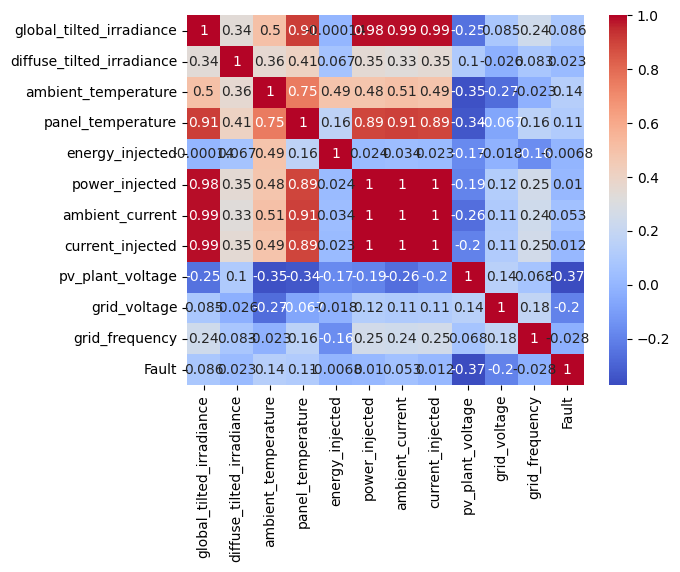

In [42]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Plot the correlation heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

### Change the values of Fault column. Set the values to 1 if they are not equal to 0.

In [43]:
# convert other fault types to 1
df['Fault'] = df['Fault'].apply(lambda x: 1 if x != 0 else 0)

### Reorder the columns

In [44]:
# Get all column names except 'fault'
cols = [c for c in df.columns if c != 'Fault']

# Append 'fault' column at the end
cols.append('Fault')

# Reorder the DataFrame using the new column order
df = df[cols]

In [45]:
# choose the directory of where GNNAD_testing files are located
df[:'2022-07-01'].to_csv('for_cross_validation.csv', index=True)